In [3]:
import os
import tempfile

import anndata as ad
import scanpy as sc
import scvi
import torch
from rich import print
import scib
from scib_metrics.benchmark import Benchmarker

scvi.settings.seed = 0

###############
dataset="Lung_atlas_public"
###############

data_dir="/goofys/users/Aleksandra_S/benchmarking_datasets/"+dataset+".h5ad"
adata=ad.read_h5ad(data_dir)

Global seed set to 0


https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html

In [7]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [34]:
adata.layers['counts'].data

array([1.       , 1.       , 1.       , ..., 1.140781 , 1.1367656,
       1.1387753], dtype=float32)

KOMENTAR: Cudno, trebalo bi da raw counts budu integeri
https://github.com/theislab/scib-reproducibility/issues/22

In [8]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [10]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [11]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 246/246: 100%|██████████| 246/246 [25:05<00:00,  5.55s/it, v_num=1, train_loss_step=549, train_loss_epoch=552]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [25:05<00:00,  6.12s/it, v_num=1, train_loss_step=549, train_loss_epoch=552]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [13]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:

In [15]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


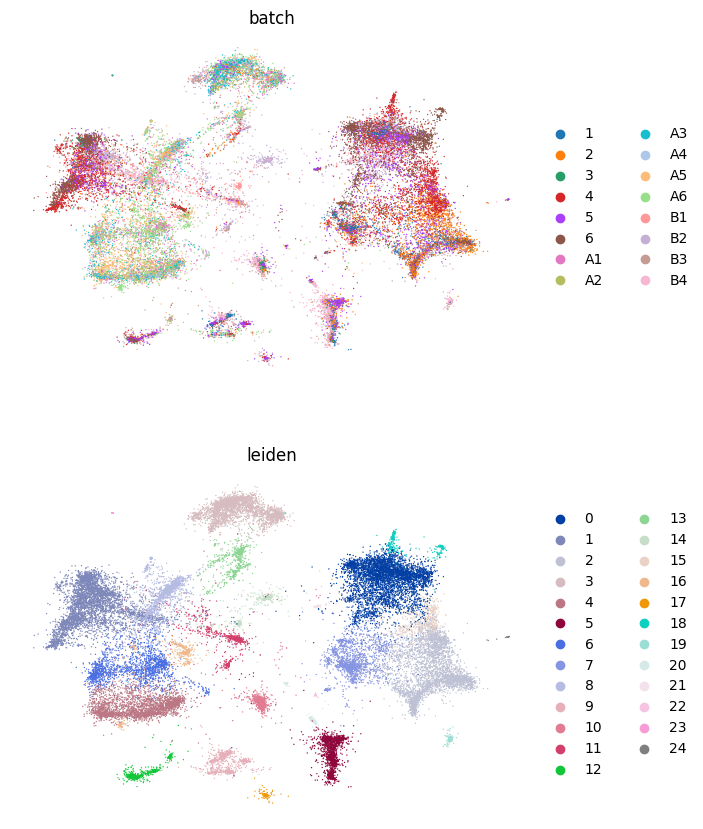

In [16]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


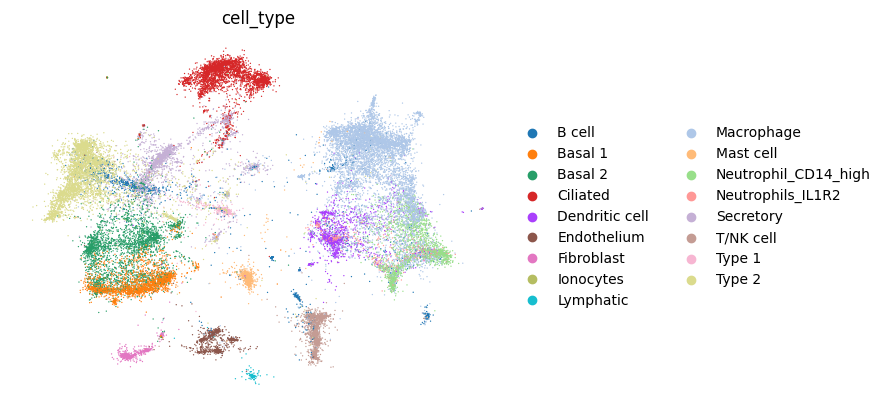

In [17]:
sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["cell_type"], frameon=False, ncols=1)

In [41]:
# bm = Benchmarker(
#     adata,
#     batch_key="batch",
#     label_key="cell_type",
#     embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY],
#     n_jobs=-1,
# )
# bm.benchmark()
# jebeno sranje

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [20]:
import scib


In [22]:
scib.me.ilisi_graph(adata, batch_key="batch", type_="embed", use_rep=SCVI_LATENT_KEY)

0.16196500409084238

## scIB

In [23]:
# iz scib-a
def scvi_scib(adata, batch, hvg=None, return_model=False, max_epochs=None):
    """scVI wrapper function

    Based on scvi-tools version >=0.16.0 (available through `conda <https://docs.scvi-tools.org/en/stable/installation.html>`_)

    .. note::
        scVI expects only non-normalized (count) data on highly variable genes!

    :param adata: preprocessed ``anndata`` object
    :param batch: batch key in ``adata.obs``
    :param hvg: list of highly variables to subset to. If ``None``, the full dataset will be used
    :return: ``anndata`` object containing the corrected feature matrix as well as an embedding representation of the
        corrected data
    """
    try:
        from scvi.model import SCVI
    except ModuleNotFoundError as e:
        raise OptionalDependencyNotInstalled(e)


    # Check for counts data layer
    if "counts" not in adata.layers:
        raise TypeError(
            "Adata does not contain a `counts` layer in `adata.layers[`counts`]`"
        )

    # Defaults from SCVI github tutorials scanpy_pbmc3k and harmonization
    n_latent = 30
    n_hidden = 128
    n_layers = 2

    # copying to not return values added to adata during setup_anndata
    net_adata = adata.copy()
    if hvg is not None:
        net_adata = adata[:, hvg].copy()
    SCVI.setup_anndata(net_adata, layer="counts", batch_key=batch)

    vae = SCVI(
        net_adata,
        gene_likelihood="nb",
        n_layers=n_layers,
        n_latent=n_latent,
        n_hidden=n_hidden,
    )
    train_kwargs = {"train_size": 1.0}
    if max_epochs is not None:
        train_kwargs["max_epochs"] = max_epochs
    vae.train(**train_kwargs)
    adata.obsm["X_emb"] = vae.get_latent_representation()

    if not return_model:
        return adata
    else:
        return vae


In [24]:
adatascib=ad.read_h5ad(data_dir)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/location' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/location' was writte

In [25]:
# ovako traze HVG-ove u tutorijalu
adatascib.raw = adatascib  # keep full dimension safe
sc.pp.highly_variable_genes(
    adatascib,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [27]:
adata_integrated_scib = scvi_scib(adatascib, batch='batch', hvg=adatascib.var.index)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 246/246: 100%|██████████| 246/246 [30:10<00:00,  7.52s/it, v_num=1, train_loss_step=543, train_loss_epoch=552]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [30:10<00:00,  7.36s/it, v_num=1, train_loss_step=543, train_loss_epoch=552]


In [28]:
sc.pp.neighbors(adata_integrated_scib, use_rep="X_emb")
sc.tl.louvain(adata_integrated_scib, resolution=1)

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'louvain'}, xlabel='UMAP1', ylabel='UMAP2'>]

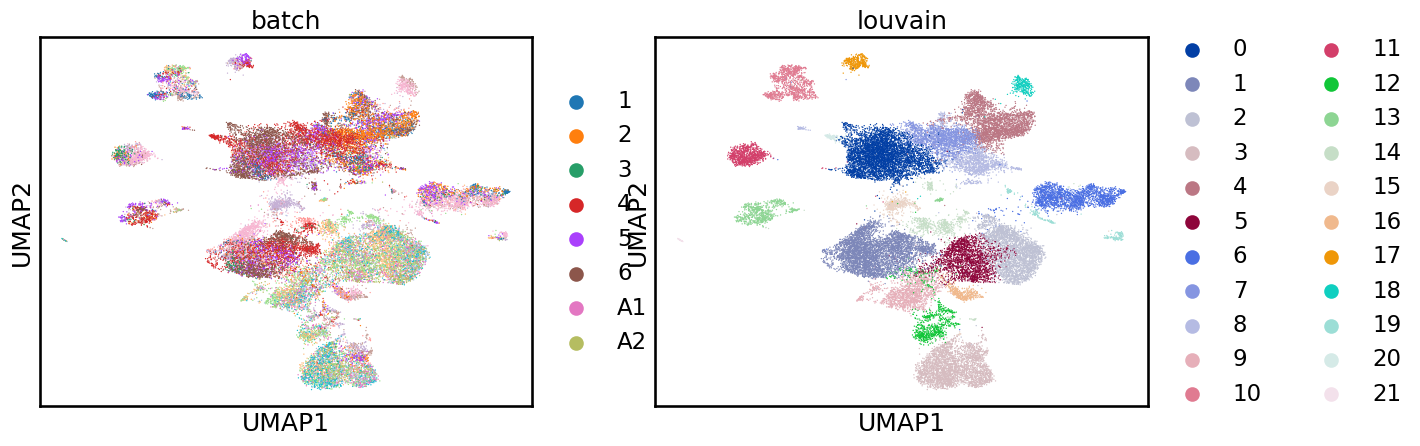

In [29]:
sc.tl.umap(adata_integrated_scib)

sc.pl.umap(adata_integrated_scib,color=["batch", "louvain"],show=False)

In [30]:
scib.me.ilisi_graph(adata_integrated_scib, batch_key="batch", type_="embed", use_rep="X_emb")

0.157483909728279

In [36]:
adata_integrated_scib

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'louvain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'neighbors', 'louvain', 'umap', 'batch_colors', 'louvain_colors'
    obsm: 'X_emb', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [37]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score

ari=adjusted_rand_score(adata_integrated_scib.obs["louvain"],adata_integrated_scib.obs["cell_type"])
nmi=normalized_mutual_info_score(adata_integrated_scib.obs["louvain"],adata_integrated_scib.obs["cell_type"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.583311747991635

NMI=0.7130673196232038